# 교통 데이터 전처리


**교통 탄소발자국 = 탄소 계수 * 거리** 로 계산

1. 교통수단별 탄소배출량 데이터(TRANS_CO2.csv) 탐색  

2. 연비연료별 탄소배출계수 데이터 생성  

3. 렌터카 데이터(RENT.csv) 탐색  

4. 가격정보 추가  
    - 올댓제주, 엔젤렌터카 크롤링 데이터 활용

5. 탑승인원 변수 생성 (인당 탄소배출량 계산)
6. 기준 항공편 설정

  

In [1]:
import pandas as pd
import requests
import logging
import folium
import numpy as np
import os
import math
import requests
import json
import folium
from folium.plugins import MiniMap
from tqdm import tqdm
from scipy.stats import mode
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
trans = pd.read_csv('data/TRANS_CO2.csv',encoding='CP949')
rent = pd.read_csv('data/RENT.csv',encoding='CP949')

## 1. 교통수단별 탄소배출량 데이터 탐색

- 단위는 kgCO2/km로 모두 같음
- 대분류가 자동차인 경우와 아닌 경우 구분하여  처리

In [3]:
trans.head()

,LG_CAT,MD_CAT,SM_CAT,FUEL_TYPE,FUEL_COST,SCALE,FACTOR
0,대중교통,버스,시내버스,CNG,NaN,kgCO2/km,0.030306
1,대중교통,버스,시내버스,경유,NaN,kgCO2/km,0.034620
2,대중교통,버스,시외버스,경유,NaN,kgCO2/km,0.045644
3,대중교통,버스,고속버스,경유,NaN,kgCO2/km,0.045644
4,대중교통,택시,택시,NaN,NaN,kgCO2/km,0.194300


In [4]:
# 중복행 확인
trans[trans.duplicated()]

,LG_CAT,MD_CAT,SM_CAT,FUEL_TYPE,FUEL_COST,SCALE,FACTOR
916,자동차,기아,K9 3.8 가솔린 플래티넘(2021),Gasoline,9.0,kgCO2/km,0.24423


In [5]:
trans = trans.drop_duplicates() # 중복행 제거

In [6]:
trans = trans.drop([0,3], axis =0) #2019년 한국가스공사 포스트 기준, cng버스 없으므로 drop + 고속버스까지 이용할 거리는 아니므로 drop

In [7]:
# 자동차 데이터 구분
trans_df = trans[trans.LG_CAT != "자동차"]
trans_car = trans[trans.LG_CAT == "자동차"]

## 2.  연비연료별 탄소배출계수 데이터 생성


### 교통수단별 탄소배출량 데이터


- 대중교통/항공/선박 등의 데이터는 그대로 사용
- 자전거, 도보는 0으로 처리
- 렌트카 데이터의 모델명 > 타입별 trans-co2 생성 > 연비 최빈값 == 타입별 최빈값 > 연료 타입별 대응 계수 선택
    - 소나타처럼 검색이 안되는 애들이 있어서 연결은 불가능 > 타입별(경차, 소형차 등)으로 분류
    - 데이터 중에서 극단의 값 보다는 보편적인 값을 고려하고 싶었고, 실제 있는 숫자로 하고 싶었음 > 최빈값 사용
    - 명확한 값을 알려주기 위해 최빈값에 대응하는 계수를 선택
- 연료타입과 연비에 따라 계수가 달라짐은 확인   


In [8]:
trans_df = trans[trans.LG_CAT != "자동차"]
trans_df = trans_df.reset_index(drop=True)

trans_df.MD_CAT[5] = "자전거"
trans_df=trans_df.drop(['SCALE'],axis=1)
trans_df.loc[len(trans_df)] = ["기타","도보",np.NaN,np.NaN,np.NaN,0]
trans_df

,LG_CAT,MD_CAT,SM_CAT,FUEL_TYPE,FUEL_COST,FACTOR
0,대중교통,버스,시내버스,경유,NaN,0.034620
1,대중교통,버스,시외버스,경유,NaN,0.045644
2,대중교통,택시,택시,NaN,NaN,0.194300
3,항공,항공,국내선,NaN,NaN,0.127738
4,기타,킥보드,NaN,NaN,NaN,0.004367
5,기타,자전거,NaN,NaN,NaN,0.000000
6,기타,선박,NaN,NaN,NaN,0.377605
7,기타,도보,NaN,NaN,NaN,0.000000


In [9]:
#1
trans_car[['FUEL_TYPE','FUEL_COST','FACTOR']].value_counts()

FUEL_TYPE        FUEL_COST  FACTOR  
Diesel           14.1       0.188210    67
Gasoline         11.6       0.189489    60
                 8.2        0.268058    58
                 9.0        0.244230    54
                 11.1       0.198025    53
                                        ..
Gasoline/Hybrid  8.9        0.246974     1
                 23.5       0.093535     1
Gasoline         15.3       0.143665     1
Electric         5.7        0.080598     1
Gasoline         11.1       0.239077     1
Length: 350, dtype: int64

In [10]:
grouped_trans_car = trans_car[['FUEL_TYPE','FUEL_COST','FACTOR']].drop_duplicates().sort_values(['FUEL_TYPE','FUEL_COST'])
grouped_trans_car

,FUEL_TYPE,FUEL_COST,FACTOR
1651,Diesel,7.6,0.349179
545,Diesel,8.2,0.323629
4021,Diesel,8.3,0.319730
2434,Diesel,8.4,0.315924
3229,Diesel,8.5,0.312207
...,...,...,...
665,LPG,10.2,0.168673
4277,LPG,10.3,0.167036
4304,LPG,10.5,0.163854
4313,LPG,10.6,0.162308


## 3. 렌터카 데이터 탐색

- 2022년 경차 순위 상승
- Top 20을 유지한 차종은 9개, Top2는 그대로 유지
- 연료 타입, 연비 관련 정보는 많이 제공되지 않았고 TRANS에서 제공한 데이터와 다름
    - trans에 비해 모델명이 단순 

In [11]:
rent2021 = rent[rent.YR==2021]
rent2022 = rent[rent.YR==2022]

In [12]:
rent2021.TYPE.value_counts()
rent2022.TYPE.value_counts()

승합       4
중형       3
중대형      3
RV       3
중소형      2
소형 RV    2
경차       2
대형 RV    2
Name: TYPE, dtype: int64

In [13]:
print(rent2021.MODEL.unique())
print(rent2022.MODEL.unique())

['3세대K5' '올뉴아반떼' '소나타 DN' '올뉴K3' 'LF소나타뉴라이즈' '더뉴그랜져' '더올뉴제네시스G80' '그랜져IG'
 '팰리세이드' 'K8' '더올뉴스포티지' '4세대카니발' '그랜드스타렉스' 'QM3' '셀토스' '더올뉴제네시스G70' '뉴K3'
 '쏘울부스터' '4세대쏘렌토']
['3세대K5' '올뉴아반떼' '더뉴그랜져' 'LF소나타뉴라이즈' '더뉴모닝' '코나' '올뉴K3' '소나타DN' '더올뉴스포티지'
 '더뉴싼타페' '뉴티볼리' '뉴그랜드스타렉스' '팰리세이드' '올뉴카니발' 'QM6' '더뉴레이' '제네시스GV70'
 '4세대카니발' '스타리아' '제네시스G70' '더올뉴제네시스G80']


In [14]:
# 렌터카 인기차종 
rent_trend = pd.DataFrame(rent2022[['MODEL','TYPE']])
rank_21 = []

for i in range(0,len(rent2022)):
    if rent2022.MODEL.iloc[i] in rent2021.MODEL.unique() :
        rank_21.append(sum(rent2021[rent2021.MODEL==rent2022.MODEL.iloc[i]].RANK))
    else :
        rank_21.append("-")

rank_21
rent_trend['21_Rank'] = rank_21
rent_trend['22_Rank'] = rent2022.RANK
rent_trend

,MODEL,TYPE,21_Rank,22_Rank
19,3세대K5,중형,1,1
20,올뉴아반떼,중소형,2,2
21,더뉴그랜져,중대형,6,3
22,LF소나타뉴라이즈,중형,5,4
23,더뉴모닝,경차,-,5
24,코나,소형 RV,-,6
25,올뉴K3,중소형,4,7
26,소나타DN,중형,-,8
27,더올뉴스포티지,RV,11,9
28,더뉴싼타페,RV,-,10


In [15]:
rent_info = pd.DataFrame()
rent_info['TYPE'] = rent_trend.TYPE.drop_duplicates()
model = []

for i in range(0, len(rent_info)):
    model.append(rent[rent.TYPE==rent_info.TYPE.iloc[i]].MODEL.unique())

rent_info['MODEL']= model

rent_info['tag'] = 0
rent_info['tag'].iloc[0] = ["K5","소나타"]
rent_info['tag'].iloc[1] = ["아반떼","K3","쏘울"]
rent_info['tag'].iloc[2] = ["그랜저","G80","K8","G70"]
rent_info['tag'].iloc[3] = ["모닝","레이"]
rent_info['tag'].iloc[4] = ['QM3', '셀토스', '코나', '티볼리']
rent_info['tag'].iloc[5] = ['스포티지', '쏘렌토', '싼타페', 'QM6']
rent_info['tag'].iloc[6] = ['카니발', '스타렉스','스타리아']
rent_info['tag'].iloc[7] = ['팰리세이드', 'GV70']

rent_info

,TYPE,MODEL,tag
19,중형,"[3세대K5, 소나타 DN, LF소나타뉴라이즈, 소나타DN]","[K5, 소나타]"
20,중소형,"[올뉴아반떼, 올뉴K3, 뉴K3, 쏘울부스터]","[아반떼, K3, 쏘울]"
21,중대형,"[더뉴그랜져, 더올뉴제네시스G80, 그랜져IG, K8, 더올뉴제네시스G70, 제네시...","[그랜저, G80, K8, G70]"
23,경차,"[더뉴모닝, 더뉴레이]","[모닝, 레이]"
24,소형 RV,"[QM3, 셀토스, 코나, 뉴티볼리]","[QM3, 셀토스, 코나, 티볼리]"
27,RV,"[더올뉴스포티지, 4세대쏘렌토, 더뉴싼타페, QM6]","[스포티지, 쏘렌토, 싼타페, QM6]"
30,승합,"[4세대카니발, 그랜드스타렉스, 뉴그랜드스타렉스, 올뉴카니발, 스타리아]","[카니발, 스타렉스, 스타리아]"
31,대형 RV,"[팰리세이드, 제네시스GV70]","[팰리세이드, GV70]"


In [16]:
for i in range(0, len(rent_info)):
    car_type = rent_info.TYPE.iloc[i]
    #car_model = rent_info.MODEL.iloc[i]
    car_tag = rent_info.tag.iloc[i]

    df = pd.DataFrame()
               
    for j in range(0,len(car_tag)) :
        df = pd.concat([df,trans_car[trans_car['SM_CAT'].str.contains(car_tag[j],case=False)]], ignore_index=True)

    fuel_types = df.FUEL_TYPE.drop_duplicates()
    
    for k in range(0, len(fuel_types)): 
        fuel = fuel_types.iloc[k]
        cost = df[df.FUEL_TYPE == fuel].FUEL_COST.mode().iloc[0]
        factor = df[(df.FUEL_TYPE == fuel) * (df.FUEL_COST == cost)].FACTOR.iloc[0]
    
        trans_df.loc[len(trans_df)] = ["자동차",car_type,car_tag,fuel,cost,factor]

In [17]:
trans_df

,LG_CAT,MD_CAT,SM_CAT,FUEL_TYPE,FUEL_COST,FACTOR
0,대중교통,버스,시내버스,경유,NaN,0.034620
1,대중교통,버스,시외버스,경유,NaN,0.045644
2,대중교통,택시,택시,NaN,NaN,0.194300
3,항공,항공,국내선,NaN,NaN,0.127738
4,기타,킥보드,NaN,NaN,NaN,0.004367
5,기타,자전거,NaN,NaN,NaN,0.000000
6,기타,선박,NaN,NaN,NaN,0.377605
7,기타,도보,NaN,NaN,NaN,0.000000
8,자동차,중형,"[K5, 소나타]",Gasoline,13.0,0.169082
9,자동차,중형,"[K5, 소나타]",Gasoline/Hybrid,19.1,0.115082


In [18]:
trans_df.FUEL_TYPE[trans_df.FUEL_TYPE == "Gasoline"] = "휘발유"
trans_df.FUEL_TYPE[trans_df.FUEL_TYPE == "Diesel"] = "경유"
trans_df.FUEL_TYPE[trans_df.FUEL_TYPE == "Electric"] = "전기"
trans_df

,LG_CAT,MD_CAT,SM_CAT,FUEL_TYPE,FUEL_COST,FACTOR
0,대중교통,버스,시내버스,경유,NaN,0.034620
1,대중교통,버스,시외버스,경유,NaN,0.045644
2,대중교통,택시,택시,NaN,NaN,0.194300
3,항공,항공,국내선,NaN,NaN,0.127738
4,기타,킥보드,NaN,NaN,NaN,0.004367
5,기타,자전거,NaN,NaN,NaN,0.000000
6,기타,선박,NaN,NaN,NaN,0.377605
7,기타,도보,NaN,NaN,NaN,0.000000
8,자동차,중형,"[K5, 소나타]",휘발유,13.0,0.169082
9,자동차,중형,"[K5, 소나타]",Gasoline/Hybrid,19.1,0.115082


## 4. 가격 정보 추가
- 예산 계산시 반영할 수 있도록 가격 정보를 추가한다

In [19]:
price = []

for i in range(0, len(trans_df)):
    if trans_df.SM_CAT[i] == "시내버스" : #간/지선버스, 현금기준
        price.append(1200)
    elif trans_df.SM_CAT[i] == "시외버스" :#(간선버스) 현금기준, 급행버스 최대금액
        price.append(3000)
    elif trans_df.MD_CAT[i] in ["도보","자전거","킥보드"] : #자전거, 킥보드 금액 고려x
        price.append(0)
    elif trans_df.MD_CAT[i] == "항공": # 에어부산 김포-제주 화-금 72000+83000 (공식홈페이지)
        price.append(155000)
    elif trans_df.MD_CAT[i] == "선박": # 목포 - 제주 화-금 193,810(https://www.directferries.co.kr/mokpo_jeju_ferry.htm) 근거x
        price.append(64603)
    elif trans_df.MD_CAT[i] == "택시": # 기본요금(2km) 3300 + 추가요금(2km, 126m당 100원)
        price.append(4900)    
    else :     #렌트카
        price.append(np.NaN)


In [20]:
trans_df['PRICE'] = price
trans_df

,LG_CAT,MD_CAT,SM_CAT,FUEL_TYPE,FUEL_COST,FACTOR,PRICE
0,대중교통,버스,시내버스,경유,NaN,0.034620,1200.0
1,대중교통,버스,시외버스,경유,NaN,0.045644,3000.0
2,대중교통,택시,택시,NaN,NaN,0.194300,4900.0
3,항공,항공,국내선,NaN,NaN,0.127738,155000.0
4,기타,킥보드,NaN,NaN,NaN,0.004367,0.0
5,기타,자전거,NaN,NaN,NaN,0.000000,0.0
6,기타,선박,NaN,NaN,NaN,0.377605,64603.0
7,기타,도보,NaN,NaN,NaN,0.000000,0.0
8,자동차,중형,"[K5, 소나타]",휘발유,13.0,0.169082,NaN
9,자동차,중형,"[K5, 소나타]",Gasoline/Hybrid,19.1,0.115082,NaN


In [21]:
# 올댓제주 렌터카 크롤링 데이터 
allthat_rent = pd.read_csv('data/ALLTHAT_제주렌터카크롤링.csv',encoding='utf-8-sig')
allthat_rent

,SM_CAT,FUEL_TYPE,PRICE
0,뉴K3(16-17년식),휘발유,36000
1,더뉴레이(21년식),휘발유,36000
2,더뉴모닝(21년식),휘발유,33000
3,쏘울부스터(19년식),휘발유,46500
4,아반테AD(16-17년식),휘발유,36000
...,...,...,...
102,G4렉스턴(18년식),경유,75000
103,QM3(17년식),경유,46800
104,QM6(17-18년식),경유,60000
105,XM3(20년식),경유,46800


In [22]:
allthat_rent['SM_CAT']=allthat_rent['SM_CAT'].str.split("(").str[0]

allthat_rent['SM_CAT']=allthat_rent['SM_CAT'].str.replace(pat='아반테',repl='아반떼',regex=False)
allthat_rent['SM_CAT']=allthat_rent['SM_CAT'].str.replace(pat='그랜져',repl='그랜저',regex=False)

In [23]:
allthat_rent['PRICE']=allthat_rent['PRICE'].str.replace(pat=',',repl='',regex=False)

allthat_rent['PRICE'] = pd.to_numeric(allthat_rent['PRICE'])

In [24]:
allthat_rent['TYPE'] = np.NaN

for i in range(0,len(rent_info)):
    car_tag = rent_info.tag.iloc[i]
    car_type = rent_info.TYPE.iloc[i]
    
    for j in range(0,len(car_tag)):
        idx = allthat_rent[allthat_rent['SM_CAT'].str.contains(car_tag[j],case=False)].index
        allthat_rent.TYPE[idx] = car_type

allthat_rent= allthat_rent[allthat_rent.TYPE.isna()== False]
allthat_rent

,SM_CAT,FUEL_TYPE,PRICE,TYPE
0,뉴K3,휘발유,36000,중소형
1,더뉴레이,휘발유,36000,경차
2,더뉴모닝,휘발유,33000,경차
3,쏘울부스터,휘발유,46500,중소형
4,아반떼AD,휘발유,36000,중소형
...,...,...,...,...
99,코나,경유,46800,소형 RV
100,팰리세이드,경유,81000,대형 RV
101,팰리세이드,휘발유,81000,대형 RV
103,QM3,경유,46800,소형 RV


In [25]:
allthat_rent2= allthat_rent.drop('SM_CAT', axis = 1)
allthat_rent2= allthat_rent2.groupby(['TYPE','FUEL_TYPE']).mean() # 논리에 따르면 max가 맞겠지만, 차 브랜드/종류에 따라 금액이 과도하게 커질 수 있어서 평균으로 보기로?
allthat_rent2 = allthat_rent2.reset_index()
allthat_rent2 = allthat_rent2.round(0)
allthat_rent2

,TYPE,FUEL_TYPE,PRICE
0,RV,경유,65500
1,RV,휘발유,69000
2,경차,휘발유,32700
3,대형 RV,경유,93000
4,대형 RV,휘발유,81000
5,소형 RV,경유,46800
6,소형 RV,휘발유,48300
7,승합,경유,72000
8,중대형,휘발유,85000
9,중소형,휘발유,39900


In [26]:
for i in range(10,len(trans_df)):
    car_type = trans_df.MD_CAT[i]
    car_fuel = trans_df.FUEL_TYPE[i]
    
    car_price = allthat_rent2[(allthat_rent2.TYPE == car_type) * (allthat_rent2.FUEL_TYPE == car_fuel)].PRICE
    
    if len(car_price) != 0 :
        trans_df.PRICE[i] = car_price.iloc[0]

In [27]:
#소형RV, RV 등을 볼때 fuel_type보다 car_type의 영향이 더 큰것으로 보임
car_type = list(trans_df[trans_df.LG_CAT=="자동차"].MD_CAT.drop_duplicates())

for i in range(0,len(car_type)) :
    index = trans_df[trans_df.MD_CAT==car_type[i]].index
    max_price = trans_df.PRICE.iloc[index].max()
    trans_df.PRICE.iloc[index] = max_price

trans_df

,LG_CAT,MD_CAT,SM_CAT,FUEL_TYPE,FUEL_COST,FACTOR,PRICE
0,대중교통,버스,시내버스,경유,NaN,0.034620,1200.0
1,대중교통,버스,시외버스,경유,NaN,0.045644,3000.0
2,대중교통,택시,택시,NaN,NaN,0.194300,4900.0
3,항공,항공,국내선,NaN,NaN,0.127738,155000.0
4,기타,킥보드,NaN,NaN,NaN,0.004367,0.0
5,기타,자전거,NaN,NaN,NaN,0.000000,0.0
6,기타,선박,NaN,NaN,NaN,0.377605,64603.0
7,기타,도보,NaN,NaN,NaN,0.000000,0.0
8,자동차,중형,"[K5, 소나타]",휘발유,13.0,0.169082,49500.0
9,자동차,중형,"[K5, 소나타]",Gasoline/Hybrid,19.1,0.115082,49500.0


## 5. 탑승인원 변수 생성 (인당 탄소배출량 계산)
- 인당 탄소배출량 계산을 위해 탑승인원 column을 추가한다.
- 여객수단인 경우(항공, 철도, 택시, 버스 등), 해당 교통수단에서 발생한 전체 탄소배출량을 여객이용수를 감안한 것이므로 1인으로 취급한다.
- 그 외 교통수단은 제시된 문제 상황에 따라 대학생 3명을 탑승 인원으로 한다.
- 구체적인 인원수 반영은 실제 계산할때

In [28]:
people = []

for i in range(0, len(trans_df)):
    if trans_df.LG_CAT[i] == "자동차" :
        people.append(3)
    elif trans_df.MD_CAT[i] == "택시" :
        people.append(4)
    elif trans_df.MD_CAT[i]  in ["도보","자전거","킥보드"]: 
        people.append(1)
    elif trans_df.MD_CAT[i] in ["버스","항공","선박"]: #다중이용 교통수단
        people.append(1)  
    else :    
        price.append(np.NaN)


trans_df["N_PEOPLE"] = people

In [29]:
trans_df

,LG_CAT,MD_CAT,SM_CAT,FUEL_TYPE,FUEL_COST,FACTOR,PRICE,N_PEOPLE
0,대중교통,버스,시내버스,경유,NaN,0.034620,1200.0,1
1,대중교통,버스,시외버스,경유,NaN,0.045644,3000.0,1
2,대중교통,택시,택시,NaN,NaN,0.194300,4900.0,4
3,항공,항공,국내선,NaN,NaN,0.127738,155000.0,1
4,기타,킥보드,NaN,NaN,NaN,0.004367,0.0,1
5,기타,자전거,NaN,NaN,NaN,0.000000,0.0,1
6,기타,선박,NaN,NaN,NaN,0.377605,64603.0,1
7,기타,도보,NaN,NaN,NaN,0.000000,0.0,1
8,자동차,중형,"[K5, 소나타]",휘발유,13.0,0.169082,49500.0,3
9,자동차,중형,"[K5, 소나타]",Gasoline/Hybrid,19.1,0.115082,49500.0,3


In [30]:
trans_df.columns

Index(['LG_CAT', 'MD_CAT', 'SM_CAT', 'FUEL_TYPE', 'FUEL_COST', 'FACTOR',
       'PRICE', 'N_PEOPLE'],
      dtype='object')

In [31]:
trans_df.to_csv('data/탄소발자국계산기_교통.csv', encoding='utf-8-sig', index=False)

## 6.  기준 항공편 설정
제주 항공여객판매대금 정산 데이터로 기준 항공편 설정 => 김포-제주 부산에어 항공편

In [32]:
bsp = pd.read_csv('data/BSP.csv',encoding='CP949')
bsp

,LSP_RID,MCT_NM,SEX_CCD,CLN_AGE,AVI_CO_CD_VL,DPF_AOT_CD_VL,ARV_AOT_CD_VL,CNT
0,20211103,주)대한항공,F,24,KE,GMP,CJU,6
1,20210920,주)대한항공,F,25,KE,GMP,CJU,6
2,20220314,주)대한항공,F,25,KE,GMP,CJU,6
3,20220503,주)대한항공,F,25,KE,GMP,CJU,6
4,20211015,주)대한항공,M,26,KE,GMP,CJU,6
...,...,...,...,...,...,...,...,...
13851,20220402,(주)아시아나항공(항공권판매,M,53,OZ,GMP,CJU,23
13852,20220331,(주)아시아나항공(항공권판매,M,37,OZ,GMP,CJU,25
13853,20220406,(주)아시아나항공(항공권판매,M,49,OZ,GMP,CJU,26
13854,20220401,(주)아시아나항공(항공권판매,M,37,OZ,GMP,CJU,27


In [33]:
bsp20s= bsp[(bsp.CLN_AGE >= 20) * (bsp.CLN_AGE <=29)]

In [34]:
bsp20s.MCT_NM.unique()

array(['주)대한항공', '에어서울 주식회사', '(주)진에어(온라인)', '에어부산  주식회사', '플라이강원주식회사',
       '(주)대한항공(항공권)', '(주)진에어(오프라인)', '(주)아시아나항공기내(원화)',
       '(주)아시아나항공(항공권판매'], dtype=object)

In [35]:
bsp20s[['MCT_NM','AVI_CO_CD_VL']].value_counts()

MCT_NM           AVI_CO_CD_VL
에어부산  주식회사       BX              591
(주)아시아나항공(항공권판매  OZ              569
에어서울 주식회사        RS              330
(주)진에어(오프라인)     LJ              275
(주)대한항공(항공권)     KE              173
주)대한항공           KE              137
(주)진에어(온라인)      LJ               10
(주)아시아나항공기내(원화)  OZ                1
플라이강원주식회사        4V                1
dtype: int64

In [36]:
#항공사 이름 정리하기
bsp20s['MCT_NM']=bsp20s['MCT_NM'].str.replace(pat='(주)',repl='',regex=False)
bsp20s['MCT_NM']=bsp20s['MCT_NM'].str.replace(pat='주식회사',repl='',regex=False)
bsp20s['MCT_NM']=bsp20s['MCT_NM'].str.replace(pat='주)',repl='',regex=False)

bsp20s['MCT_NM'] = bsp20s['MCT_NM'].str.split("(").str[0]
bsp20s['MCT_NM']=bsp20s['MCT_NM'].str.replace(pat='기내',repl='',regex=False)
bsp20s.MCT_NM.unique()

array(['대한항공', '에어서울 ', '진에어', '에어부산  ', '플라이강원', '아시아나항공'], dtype=object)

In [37]:
label = bsp20s[['DPF_AOT_CD_VL','CNT']].groupby('DPF_AOT_CD_VL').sum().index
values= bsp20s[['DPF_AOT_CD_VL','CNT']].groupby('DPF_AOT_CD_VL').sum().CNT

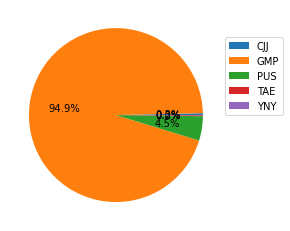

In [38]:
plt.pie(values,autopct='%.1f%%')
plt.legend(label, loc = (1, 0.5))
plt.show()

In [39]:
bsp20s[['MCT_NM','CNT']].groupby('MCT_NM').sum()

,CNT
MCT_NM,
대한항공,2215
아시아나항공,4524
에어부산,4838
에어서울,2456
진에어,2387
플라이강원,6


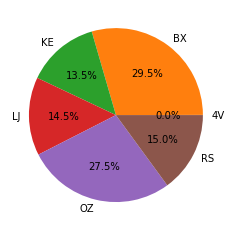

In [40]:
label = bsp20s[['AVI_CO_CD_VL','CNT']].groupby('AVI_CO_CD_VL').sum().index
values= bsp20s[['AVI_CO_CD_VL','CNT']].groupby('AVI_CO_CD_VL').sum().CNT

plt.pie(values, labels=label,autopct='%.1f%%')
plt.show()

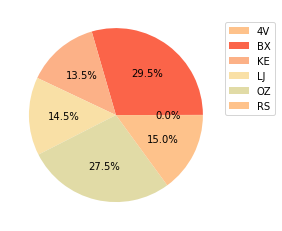

In [41]:
label = bsp20s[['AVI_CO_CD_VL','CNT']].groupby('AVI_CO_CD_VL').sum().index
values= bsp20s[['AVI_CO_CD_VL','CNT']].groupby('AVI_CO_CD_VL').sum().CNT

colors = ['#FEC28B', '#FB6449', '#FCB187', '#F9E0A6','#E1DBA6']

plt.pie(values, colors=colors,autopct='%.1f%%')
plt.legend(label, loc = (1, 0.5))
plt.show()